### Bessel differential equation using ML

Trying out these features: custom monitor callback and early stopping callback

In [1]:
# Libraries
from neurodiffeq import diff
from neurodiffeq.conditions import DirichletBVP
from neurodiffeq.networks import FCNN
from neurodiffeq.generators import Generator1D
from neurodiffeq.solvers import Solver1D

from torch.optim import Adam
from torch.nn import Tanh, MSELoss

from numpy import argsort, sort
import matplotlib.pyplot as plt

In [2]:
# Bessel ODE
nu = 2
ode_system = lambda y, t: [t ** 2 * diff(y, t, 2) + t * diff(y, t, 1) + (t ** 2 - nu ** 2) * y]

# Dirichlet conditions
conditions = DirichletBVP(t_0 = 0,
                          u_0 = 0,
                          t_1 = 1,
                          u_1 = 0.5)

# NN
nets = FCNN(n_input_units = 1,
            n_output_units = 1,
            hidden_units = (16, 16, 16),
            actv = Tanh)

# Train points
train_generator = Generator1D(size = 500,
                              t_min = 0.0,
                              t_max = 1.0,
                              method = 'equally-spaced')

# Test points
valid_generator = Generator1D(size = 250,
                              t_min = 0.0,
                              t_max = 1.0,
                              method = 'equally-spaced')

# Optimizer algorithm
optimizer = Adam(nets.parameters(), lr = 1e-03)

# MSELoss function
loss_fn = MSELoss()

# Early stopping callback
class EarlyStoppingCallback:
    def __init__(self, monitor = 'valid_loss', patience = 200, min_delta = 1e-5):
        self.monitor = monitor
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, solver): # This method is called automatically by the solver after each epoch.
        # Access the appropriate history from the solver
        if self.monitor == 'train_loss':
            history = solver.metrics_history["train_loss"]
        elif self.monitor == 'valid_loss':
            history = solver.metrics_history["valid_loss"]

        # Get current loss (last entry in history)
        current_loss = history[-1]

        # Check for improvement
        if current_loss < (self.best_loss - self.min_delta):
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1

        # Stop training if patience is exceeded
        if self.counter >= self.patience:
            print(f'EarlyStopping: Training stopped after {len(history)} epochs. Loss final value: {self.best_loss:.6e}')
            solver._stop_training = True

# Custom monitor callback
class PrintLossesCallback:
    def __init__(self, print_every = 100):
        self.print_every = print_every
    
    def __call__(self, solver):
        # Get current epoch from the length of training history
        current_epoch = len(solver.metrics_history["train_loss"])
        
        # Check if it's time to print (every print_every epochs)
        if current_epoch % self.print_every == 0:
            # Get current losses
            train_loss = solver.metrics_history["train_loss"][-1]
            valid_loss = solver.metrics_history["valid_loss"][-1]
            
            # Format and print
            print(f"Epoch {current_epoch:4d} | Train Loss: {train_loss:.6e} | Valid Loss: {valid_loss:.6e}")

print_losses = PrintLossesCallback()
early_stop = EarlyStoppingCallback()

In [3]:
# Solution
sol = Solver1D(ode_system = ode_system,
               conditions = [conditions],
               t_min = 0,
               t_max = 1,
               nets = [nets],
               train_generator = train_generator,
               valid_generator = valid_generator,
               optimizer = optimizer,
               loss_fn = loss_fn)

sol.fit(3_000, callbacks = [print_losses, early_stop]) # Training with callbacks

Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch  100 | Train Loss: 3.297524e-03 | Valid Loss: 3.310928e-03
Epoch  200 | Train Loss: 3.075850e-03 | Valid Loss: 3.093141e-03
Epoch  300 | Train Loss: 2.881433e-03 | Valid Loss: 2.897648e-03
Epoch  400 | Train Loss: 2.680947e-03 | Valid Loss: 2.696031e-03
Epoch  500 | Train Loss: 2.464755e-03 | Valid Loss: 2.478412e-03
Epoch  600 | Train Loss: 2.204908e-03 | Valid Loss: 2.216473e-03
Epoch  700 | Train Loss: 1.850792e-03 | Valid Loss: 1.859086e-03
Epoch  800 | Train Loss: 1.336339e-03 | Valid Loss: 1.339847e-03
Epoch  900 | Train Loss: 6.721730e-04 | Valid Loss: 6.711440e-04
Epoch 1000 | Train Loss: 1.609294e-04 | Valid Loss: 1.599948e-04
Epoch 1100 | Train Loss: 2.619482e-05 | Valid Loss: 2.650858e-05
Epoch 1200 | Train Loss: 1.623419e-05 | Valid Loss: 1.654795e-05
Epoch 1300 | Train Loss: 1.520574e-05 | Valid Loss: 1.547144e-05
EarlyStopping: Training stopped after 1335 epochs. Loss final value: 1.969051e-05


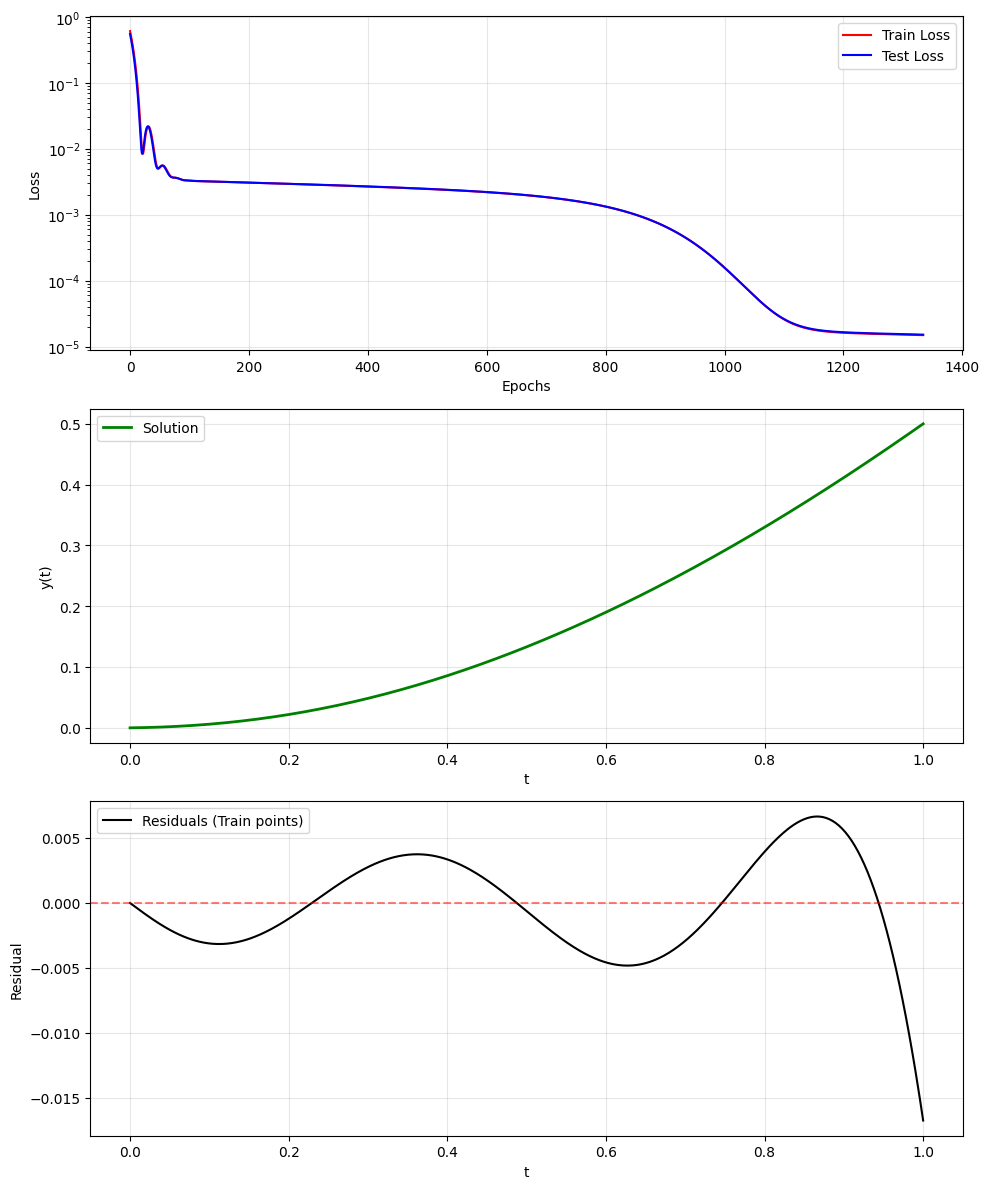

In [4]:
# Get data
train_loss = sol.metrics_history["train_loss"]
valid_loss = sol.metrics_history["valid_loss"]

t_test = valid_generator.get_examples()
solution = sol.get_solution()(t_test).detach().numpy().flatten()
t_test = t_test.detach().numpy().flatten()

t_train = train_generator.get_examples()
residuals = sol.get_residuals(t_train).detach().numpy().flatten()
t_train = t_train.detach().numpy().flatten()

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10, 12))

# Plot 1: Loss history
ax1.plot(train_loss, 'r-', label = 'Train Loss', linewidth = 1.5)
ax1.plot(valid_loss, 'b-', label = 'Test Loss', linewidth = 1.5)
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha = 0.3)

# Plot 2: Solution
ax2.plot(sort(t_test), solution[argsort(t_test)], 'g-', label = 'Solution', linewidth = 2)
ax2.set_xlabel('t')
ax2.set_ylabel('y(t)')
ax2.legend()
ax2.grid(True, alpha = 0.3)

# Plot 3: Residuals
ax3.plot(sort(t_train), residuals[argsort(t_train)], 'k-', label = 'Residuals (Train points)', linewidth = 1.5)
ax3.axhline(y = 0, color = 'r', linestyle = '--', alpha = 0.5)
ax3.set_xlabel('t')
ax3.set_ylabel('Residual')
ax3.legend()
ax3.grid(True, alpha = 0.3)

plt.tight_layout()
plt.show()